# Feature Engineering & PreProcessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pickle
import time
import os
import json


import librosa
from scipy.stats import skew
from imblearn.over_sampling import SMOTE

### Data Imports

In [2]:
with open('pickles/df.pkl', 'rb') as f:
    df = pickle.load(f)
    
with open('pickles/df_librosa.pkl', 'rb') as f:
    df_librosa = pickle.load(f)
    
with open('pickles/df_meta.pkl', 'rb') as f:
    df_meta = pickle.load(f)

In [3]:
## saving a redundant df

In [4]:
# df_backup = df_librosa

## Unpacking Metric Columns

In the Librosa call within the last notebook, we created a dataframe that contains several columns, each with a list of values within each row. We'll need to unpack these values into their own features to allow a model to iterate over each value.

In [5]:
def unpack_lists(df, column):
    max_cols = max(df[column].apply(len))
    col_names = [f"{column}_{i}" for i in range(max_cols)]
    unpacked = pd.DataFrame(df[column].to_list(), columns=col_names)
    df = pd.concat([df.drop(columns=[column]), unpacked], axis=1)

    return df

In [6]:
# Unpack each list in the columns of interest
mfcc_cols = unpack_lists(df_librosa, 'mfccs')
# spectral_centroids_cols = unpack_lists(df_librosa, 'spectral_centroids')
# spectral_bandwidth_cols = unpack_lists(df_librosa, 'spectral_bandwidth')
# spectral_contrast_cols = unpack_lists(df_librosa, 'spectral_contrast')
# zero_crossing_rate_cols = unpack_lists(df_librosa, 'zero_crossing_rate')
# chroma_cens_cols = unpack_lists(df_librosa, 'chroma_cens')
#mel_spectrogram_cols = unpack_lists(df_librosa, 'mel_spectrogram')

In [7]:
df_unpacked = pd.merge(df_librosa[['filename']], mfcc_cols, on = 'filename')

In [8]:
df_unpacked.shape

(20100, 21)

In [9]:
df_unpacked

,filename,spectral_centroids,spectral_bandwidth,spectral_contrast,zero_crossing_rate,chroma_cens,mel_spectrogram,utteranceId,mfccs_0,mfccs_1,...,mfccs_3,mfccs_4,mfccs_5,mfccs_6,mfccs_7,mfccs_8,mfccs_9,mfccs_10,mfccs_11,mfccs_12
0,reportorial_2011_0251_008.wav,6025.788734,3433.736990,10.539838,0.503367,0.289531,0.063026,reportorial_2011_0251_008,-123.790871,-100.464346,...,-98.432731,-95.518505,-92.538542,-91.913841,-96.206612,-90.133061,-90.514924,-89.705499,-88.046645,-91.630449
1,novel_2011_0011_148.wav,6052.174018,3429.746529,10.482806,0.505314,0.287728,0.060019,novel_2011_0011_148,-121.258729,-95.909976,...,-87.418884,-85.580306,-85.042187,-82.940798,-83.121582,-82.290868,-80.702449,-86.572884,-91.970859,-97.276586
2,news_2007_0095_053.wav,6027.433333,3430.829633,10.486624,0.504346,0.284328,0.062947,news_2007_0095_053,-121.016730,-103.902689,...,-102.913451,-105.015835,-96.336047,-88.814185,-85.983866,-89.011694,-92.763767,-95.120740,-95.710464,-93.744948
3,sus_2009_0092_061.wav,6200.455881,3385.585447,10.848807,0.525013,0.285707,0.062730,sus_2009_0092_061,-118.746449,-102.240780,...,-99.461696,-100.709934,-100.429992,-100.107773,-95.118919,-93.924653,-93.955773,-95.869571,-92.140983,-91.697214
4,conv_2009_0044-1_062.wav,6096.182552,3413.363463,10.383577,0.513519,0.295485,0.059877,conv_2009_0044-1_062,-120.820588,-100.116539,...,-94.124432,-92.134611,-83.385746,-85.186897,-89.113236,-94.933606,-99.399660,-99.632676,-102.023701,-100.308676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20095,sus_2009_0092_078.wav,6142.460766,3411.697247,10.908465,0.514800,0.286174,0.059629,sus_2009_0092_078,-123.979827,-102.934858,...,-99.171719,-95.796697,-96.490377,-95.590069,-94.246391,-90.730787,-87.152813,-96.212003,-95.722584,-92.996185
20096,reportorial_2011_0339_005.wav,6072.422756,3408.446598,10.477285,0.508882,0.300923,0.065870,reportorial_2011_0339_005,-123.726313,-100.206773,...,-90.005596,-92.091608,-91.887152,-90.369654,-94.140799,-90.333144,-84.422011,-83.674684,-81.680704,-84.441635
20097,news_2008_0016_012.wav,5874.128509,3487.799038,10.705631,0.473617,0.278925,0.074210,news_2008_0016_012,-115.998063,-101.525838,...,-88.468474,-89.236251,-84.059074,-85.582394,-87.617431,-84.935546,-89.690004,-91.216627,-89.335481,-92.677418
20098,reportorial_2011_0251_011.wav,5994.323238,3454.331429,10.473982,0.499616,0.285274,0.059626,reportorial_2011_0251_011,-123.807941,-100.586427,...,-100.571671,-101.610383,-101.637033,-100.730312,-104.457658,-99.177351,-99.274907,-97.487351,-96.373047,-98.929156


### MFCC Reduction

The first 13 values in the mfcc array will be the most important values for classifying speech. This is because these coefficients typically capture the most important spectral features related to the shape and size of the vocal tract during speech production, which are relevant for speech recognition, speaker identification, and other speech processing tasks. The higher-order MFCCs (14 and above) capture more fine-grained spectral details, but they are generally less important for speech analysis.

We'll remove all excess mfcc values and continue evaluating the data.

In [10]:
#df_librosa['mfccs'] = [i[:13] if isinstance(i, np.ndarray) else i for i in df_librosa['mfccs']]

In [11]:
#df_librosa

### Mean Metrics

Because upacking each column, as shown above, returns such a large number of values(shape 20100,7033), we'll take the mean value of each iteration and report that value.

This process may be iterative because I'm not certain that the model will be effective given simply the mean value of each metric.

In [12]:
#df_librosa

In [13]:
#df_no_dupes = df_librosa['mfccs'].drop_duplicates()

The above code returns a shape that is the same as the original df, so there are no duplicates.

In [14]:
def mean_metrics(df,column):
    return df[column].apply(np.mean)

In [15]:
# mfcc_mean = mean_metrics(df_librosa, 'mfccs')
# spectral_centroids_mean = mean_metrics(df_librosa, 'spectral_centroids')
# spectral_bandwidth_mean = mean_metrics(df_librosa, 'spectral_bandwidth')
# spectral_contrast_mean = mean_metrics(df_librosa, 'spectral_contrast')
# zero_crossing_rate_mean = mean_metrics(df_librosa, 'zero_crossing_rate')
# chroma_cens_mean = mean_metrics(df_librosa, 'chroma_cens')
# mel_spectrogram_mean = mean_metrics(df_librosa, 'mel_spectrogram')

In [16]:
# df_mean_metrics = pd.concat([df_librosa[['filename']], mfcc_mean, spectral_centroids_mean, spectral_bandwidth_mean, spectral_contrast_mean, zero_crossing_rate_mean, chroma_cens_mean,mel_spectrogram_mean], axis=1)

In [17]:
# df_mean_metrics.sort_values('filename', ascending = True)

In [18]:
def normalize(x):
    return (x - x.mean()) / x.std()

In [19]:
# df_mean_metrics.columns

In [20]:
# df_mean_metrics[['mfccs', 'spectral_centroids', 'spectral_bandwidth', 'spectral_contrast', 'zero_crossing_rate', 'chroma_cens', 'mel_spectrogram']] = df_mean_metrics[['mfccs', 'spectral_centroids', 'spectral_bandwidth', 'spectral_contrast', 'zero_crossing_rate', 'chroma_cens', 'mel_spectrogram']].apply(normalize, axis=0)

In [21]:
# df_mean_metrics

### Cleaning & Dropping Columns

We want to join the metadata dataframe with our metrics dataframe. The metadata df contains the model id, which we'll use as our target variable.

First we need to clean the metadata df to prepare it for joining.There are several columns within the dataset that are used to describe the individual utterance each listener was tasked with listening to, as well as the listeners themselves.

These IDs are not important to our task of modelling the data and so we will drop them.

In [22]:
df_unpacked.sort_values('utteranceId', ascending = True)

,filename,spectral_centroids,spectral_bandwidth,spectral_contrast,zero_crossing_rate,chroma_cens,mel_spectrogram,utteranceId,mfccs_0,mfccs_1,...,mfccs_3,mfccs_4,mfccs_5,mfccs_6,mfccs_7,mfccs_8,mfccs_9,mfccs_10,mfccs_11,mfccs_12
5578,LJ002-0181_033.wav,6044.127526,3424.732936,10.517691,0.505480,0.289781,0.062423,LJ002-0181_033,-123.816471,-99.990546,...,-91.370020,-91.571962,-94.729684,-98.715758,-101.583898,-99.343910,-100.800989,-97.941375,-95.430602,-95.630399
2028,LJ002-0181_046.wav,6041.736217,3431.684902,10.517671,0.505834,0.279444,0.062364,LJ002-0181_046,-123.767422,-99.812221,...,-91.898105,-93.314854,-96.390676,-97.362598,-103.904901,-98.447886,-97.569816,-97.495506,-92.961921,-94.011328
15751,LJ002-0181_058.wav,6003.451340,3455.363301,10.501171,0.499427,0.292976,0.060302,LJ002-0181_058,-123.791475,-99.885099,...,-91.826909,-93.012285,-97.467701,-97.725756,-100.104526,-98.713285,-98.908031,-98.405036,-93.211640,-93.969821
15778,LJ002-0181_070.wav,6037.705905,3427.132549,10.588121,0.503848,0.293344,0.062887,LJ002-0181_070,-123.825716,-93.840931,...,-87.439884,-89.492533,-97.599421,-102.477909,-103.034249,-101.760782,-99.253990,-100.935888,-97.600267,-96.612335
743,LJ002-0181_079.wav,6038.716552,3431.769928,10.488919,0.504536,0.290221,0.060903,LJ002-0181_079,-123.807143,-93.921737,...,-87.971695,-91.831696,-95.592183,-99.563506,-104.379730,-99.992828,-97.288660,-96.558635,-95.208310,-94.436037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2600,wiki_0100_113.wav,6002.407055,3456.623564,10.338418,0.499559,0.285220,0.059141,wiki_0100_113,-124.109589,-100.833590,...,-100.905210,-91.221240,-87.323175,-84.089835,-88.505228,-95.910172,-95.744091,-93.440740,-98.538719,-99.221259
20017,wiki_0100_118.wav,6010.843859,3444.372835,10.179725,0.501168,0.289354,0.060290,wiki_0100_118,-125.877900,-103.371275,...,-97.712791,-92.749660,-88.768975,-84.081050,-81.260142,-89.676296,-86.261415,-93.955875,-102.055568,-100.119570
16192,wiki_0100_121.wav,6021.260243,3449.250751,10.672808,0.501354,0.300156,0.059590,wiki_0100_121,-121.118127,-104.597138,...,-98.421643,-96.564541,-91.040451,-82.666054,-86.331762,-89.036636,-89.512541,-93.294269,-99.655386,-99.592094
16304,wiki_0100_123.wav,6024.247078,3457.423765,10.665179,0.503229,0.295028,0.058849,wiki_0100_123,-123.035726,-103.337824,...,-97.230842,-100.016376,-91.130900,-87.574866,-92.991652,-87.942054,-87.579909,-88.919122,-97.825911,-99.845118


In [23]:
df.columns

Index(['utteranceId', 'choice', 'sentenceId', 'systemId', 'modelId',
       'testpageId', 'locale', 'listenerId', 'isNative', 'wrongValidation',
       'lowNatural', 'sameScores', 'highSynthetic', 'clean',
       'listenerReliability', 'MOS'],
      dtype='object')

In [24]:
drop_cols = ['sentenceId','systemId','testpageId','listenerId','wrongValidation','sameScores']

In [25]:
df = df.drop(drop_cols,axis=1)

In [26]:
df

,utteranceId,choice,modelId,locale,isNative,lowNatural,highSynthetic,clean,listenerReliability,MOS
0,novel_2007_0098_015,4,m1,gb,1,1,1,1,1.00,3.590156
1,novel_2007_0098_015,2,m1,gb,0,1,1,1,1.00,3.590156
2,novel_2007_0098_015,2,m1,gb,1,1,1,1,1.00,3.590156
3,novel_2007_0098_015,5,m1,gb,1,1,1,1,1.00,3.590156
4,novel_2007_0098_015,5,m1,gb,1,0,0,0,0.46,3.590156
...,...,...,...,...,...,...,...,...,...,...
339203,reportorial_2011_0141_160,3,m5,us,1,1,0,0,0.71,3.436844
339204,reportorial_2011_0141_160,4,m5,us,1,1,0,0,0.29,3.436844
339205,reportorial_2011_0141_160,4,m5,us,1,0,0,0,0.32,3.436844
339206,reportorial_2011_0141_160,2,m5,us,1,1,1,1,0.44,3.436844


In [27]:
df_unpacked['filename'] = df_unpacked['filename'].str.rstrip('.wav')
df_unpacked['utteranceId'] =  df_unpacked['filename']
df_unpackedunpacked = df_unpacked.drop('filename',axis = 1)

### Merging Metadata & Metrics

Now we can merge the two dataframes. This is the dataframe we'll use for modelling.

In [28]:
df_model = pd.merge(df, df_unpacked, on = 'utteranceId')
df_model

,utteranceId,choice,modelId,locale,isNative,lowNatural,highSynthetic,clean,listenerReliability,MOS,...,mfccs_3,mfccs_4,mfccs_5,mfccs_6,mfccs_7,mfccs_8,mfccs_9,mfccs_10,mfccs_11,mfccs_12
0,novel_2007_0098_015,4,m1,gb,1,1,1,1,1.00,3.590156,...,-92.573901,-88.638488,-84.635204,-86.060635,-87.640126,-93.160796,-98.000245,-98.876869,-97.915545,-93.276859
1,novel_2007_0098_015,2,m1,gb,0,1,1,1,1.00,3.590156,...,-92.573901,-88.638488,-84.635204,-86.060635,-87.640126,-93.160796,-98.000245,-98.876869,-97.915545,-93.276859
2,novel_2007_0098_015,2,m1,gb,1,1,1,1,1.00,3.590156,...,-92.573901,-88.638488,-84.635204,-86.060635,-87.640126,-93.160796,-98.000245,-98.876869,-97.915545,-93.276859
3,novel_2007_0098_015,5,m1,gb,1,1,1,1,1.00,3.590156,...,-92.573901,-88.638488,-84.635204,-86.060635,-87.640126,-93.160796,-98.000245,-98.876869,-97.915545,-93.276859
4,novel_2007_0098_015,5,m1,gb,1,0,0,0,0.46,3.590156,...,-92.573901,-88.638488,-84.635204,-86.060635,-87.640126,-93.160796,-98.000245,-98.876869,-97.915545,-93.276859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339203,reportorial_2011_0141_160,3,m5,us,1,1,0,0,0.71,3.436844,...,-94.706398,-85.911405,-84.686248,-87.217177,-90.778308,-86.241988,-87.805563,-92.076305,-93.107499,-96.738710
339204,reportorial_2011_0141_160,4,m5,us,1,1,0,0,0.29,3.436844,...,-94.706398,-85.911405,-84.686248,-87.217177,-90.778308,-86.241988,-87.805563,-92.076305,-93.107499,-96.738710
339205,reportorial_2011_0141_160,4,m5,us,1,0,0,0,0.32,3.436844,...,-94.706398,-85.911405,-84.686248,-87.217177,-90.778308,-86.241988,-87.805563,-92.076305,-93.107499,-96.738710
339206,reportorial_2011_0141_160,2,m5,us,1,1,1,1,0.44,3.436844,...,-94.706398,-85.911405,-84.686248,-87.217177,-90.778308,-86.241988,-87.805563,-92.076305,-93.107499,-96.738710


## Binarizing Target Variable

Because the modelId column provides several different iterations of the model used to generate speech and only a single model for human speech, we'll binarize the columns. Once we are done, 1 will correspond to the 'm0' model and 0 will correspond with the generative speech models

In [29]:
df_model['modelId'].value_counts()

m5    117646
m4    105429
m3     66127
m1     24969
m0     17855
m2      7182
Name: modelId, dtype: int64

In [30]:
# 0 is generated, 1 is human
df_model['modelId'] = np.where(df_model['modelId'] == 'm0',1,0)

In [31]:
df_model['modelId'].value_counts()

0    321353
1     17855
Name: modelId, dtype: int64

## SMOTE

Because our target class is unbalanced, we'll oversample the minority class using SMOTE

In [35]:
# sm = SMOTE(random_state=2023,sampling_strategy='auto')

In [36]:
# features = df_model.drop(columns = ['modelId'])
# target = df_model['modelId']

In [37]:
# features_resampled,target_resampled = sm.fit_resample(features,target)

In [ ]:
# df_resampled = pd.concat([features_resampled,target_resampled],axis=1)

In [ ]:
# df_resampled

### ReSampling The Metric Data

In [ ]:
# df_metrics = df_metrics.drop_duplicates()

In [ ]:
# sm = SMOTE(random_state=2023,sampling_strategy='auto')

In [ ]:
# features = df_metrics.drop(columns = ['modelId'])
# target = df_metrics['modelId']

In [ ]:
# features_resampled,target_resampled = sm.fit_resample(features,target)
# df_metrics_re = pd.concat([features_resampled,target_resampled],axis=1)

In [ ]:
# df_metrics_re['modelId'].value_counts()

Now we have an equally balanced target feature that we'll use to model on the following worksheet

## Pickling

In [ ]:
# with open('pickles/df_resampled.pkl', 'wb') as f:
#     pickle.dump(df_resampled, f)
    
# with open('pickles/df_metrics_re.pkl', 'wb') as f:
#     pickle.dump(df_metrics_re, f)
    
# with open('pickles/df_metrics.pkl', 'wb') as f:
#     pickle.dump(df_metrics, f)
    
# with open('pickles/df_backup.pkl', 'wb') as f:
#     pickle.dump(df_backup, f)

In [43]:
with open('pickles/df_model.pkl', 'wb') as f:
    pickle.dump(df_model, f)
    
# with open('pickles/df_unpacked.pkl', 'wb') as f:
#     pickle.dump(df_unpacked, f)

In [ ]:
mfcc_cols = ['mfccs_0', 'mfccs_1', 'mfccs_2', 'mfccs_3', 'mfccs_4', 'mfccs_5', 'mfccs_6', 'mfccs_7', 'mfccs_8', 'mfccs_9', 'mfccs_10', 'mfccs_11', 'mfccs_12']

In [39]:
generated = df_model[df_model['modelId'] != 1]
human = df_model[df_model['modelId'] == 1]

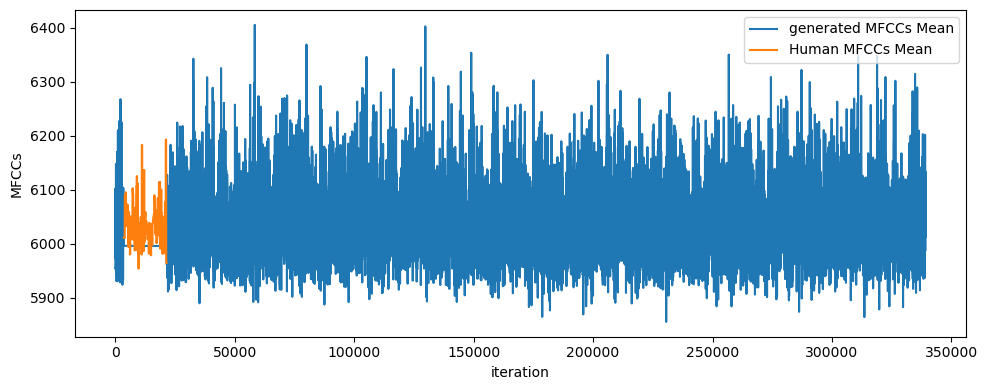

In [42]:
plt.figure(figsize=(10, 4))
plt.plot(generated['spectral_centroids'], label='generated MFCCs Mean')
plt.plot(human['spectral_centroids'], label='Human MFCCs Mean')
plt.ylabel('MFCCs')
plt.xlabel('iteration')

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
-